In [ ]:
using Revise
using FUSE
using IMAS
using Printf
using Plots;
FUSE.logging(Logging.Info);

## FPP custom case

In [ ]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars);

In [ ]:
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

R0 = ini.equilibrium.R0
ϵ = ini.equilibrium.ϵ
a = R0 * ϵ

RiPlasma = R0 - a

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.2
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.7
ini.core_profiles.helium_fraction = 0.04

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = 25e6

ini.pf_active.n_coils_outside = 8

ini.requirements.flattop_duration = 24*3600.0

In [ ]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 0.825

act.ActorHFSsizing.do_plot = false
act.ActorHFSsizing.verbose = false
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0
act.ActorFluxSwing.operate_oh_at_j_crit = false

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :Sheffield
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorOpt.convergence_error = 1e-2
act.ActorOpt.max_iter = 5
act.ActorOpt.verbose = false

## ITER ods case

In [135]:
if true
    ini, act = FUSE.case_parameters(:ITER; init_from=:scalars);

    ini.requirements.flattop_duration = 0.0
    
    ini.equilibrium.pressure_core = 1.5e6
    ini.equilibrium.B0 = 5.3
    
    ini.ic_antennas.power_launched = 0.0
    
    dd = IMAS.dd()
    FUSE.init(dd, ini, act; do_plot=false);

    dd.build.layer[4].material = "Steel"
    dd.build.layer[5].type = 4
    dd.build.layer[5].name = "hfs blanket"
    dd.build.layer[9].type = 4
    dd.build.layer[9].name = "lfs blanket"
    dd.build.layer[10].material = "Steel"
    dd.build.layer[13].material = "Steel"
        
end
        
act.ActorHFSsizing.j_tolerance = 0.01
act.ActorHFSsizing.stress_tolerance = 0.01

act.ActorOpt.convergence_error = 1e-3

0.001

## Run two costing models

In [138]:
dd_Shef = deepcopy(dd);
dd_GASC = deepcopy(dd);

act_Shef= deepcopy(act)
act_GASC = deepcopy(act)

act_Shef.ActorCosting.model = :Sheffield
act_GASC.ActorCosting.model = :GASC



:GASC

In [139]:

FUSE.ActorWholeFacility(dd_Shef, act_Shef);
FUSE.ActorWholeFacility(dd_GASC, act_GASC);


if false
    
    FUSE.ActorNeutronics(dd_Shef, act_Shef);
    #FUSE.ActorBlanket(dd_Shef, act_Shef);
    FUSE.ActorDivertors(dd_Shef, act_Shef);
    FUSE.ActorBalanceOfPlant(dd_Shef, act_Shef);
    FUSE.ActorCosting(dd_Shef, act_Shef);

    FUSE.ActorNeutronics(dd_GASC, act_GASC);
    #FUSE.ActorBlanket(dd_GASC, act_GASC);
    FUSE.ActorDivertors(dd_GASC, act_GASC);
    FUSE.ActorBalanceOfPlant(dd_GASC, act_GASC);
    FUSE.ActorCosting(dd_GASC, act_GASC);

end


 * Status: success

 * Candidate solution
    Final objective value:     2.569246e-04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    179
    f(x) calls:    339
[OH.thickness, dd.build.oh.technology.fraction_stainless] = [0.7570353977783455, 0.50745518704067]
[TFhfs.thickness, dd.build.tf.technology.fraction_stainless] = [0.7421018054673212, 0.7155808213045647]

target_B0 = 5.300256102789031
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 5.300256102789031

dd.build.oh.flattop_duration = 0.0
dd.requirements.flattop_duration = 0.0

dd.build.oh.max_j = 2.1885497935732663e7
dd.build.oh.critical_j = 6.581527550323001e6

dd.build.tf.max_j = 1.979040353491043e7
dd.build.tf.critical_j = 1.998829196518352e7

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 7.920789335541773e8
stainless_steel.yield_strength = 8.0e8

maximum(dd.solid_mechanics.center_stac

LoadError: AssertionError: OH exceeds critical current: 335.85444634361784%

In [140]:
plot(dd_Shef.costing)

LoadError: costing.construction_start_year is missing

In [141]:
plot(dd_GASC.costing)

LoadError: costing.construction_start_year is missing

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 6.2 [m]                   B0 → 5.3 [T]                   Te0 → 14.4 [keV]               ne0 → 1.35e+20 [m⁻³]           
a → 1.97 [m]                   ip → 15 [MA]                   Ti0 → 14.4 [keV]               ne_ped → 8.31e+19 [m⁻³]        
1/ϵ → 3.15 [m]                 q95 → 3.17                     <Te> → 9.62 [keV]              <ne> → 1.03e+20 [m⁻³]          
κ → 1.87                       <Bpol> → 1.02 [T]              <Ti> → 9.62 [keV]              ne0/<ne> → 1.31                
δ → 0.6                        βpol_MHD → 0.963               Te0/<Te> → 1.49                fGW → 0.906                    
ζ → -0.218                     βtor_MHD → 0.0386              Ti0/<Ti> → 1.49                zeff_ped → 2                   


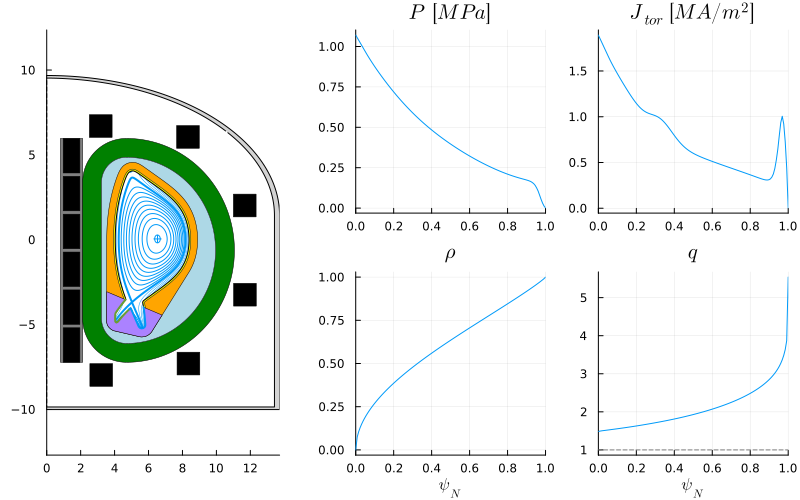

​


13×9 DataFrame
 Row │ group   details  type      ΔR        R_start    R_end      material   area       volume    
     │ String  String   String    Float64   Float64    Float64    String     Float64    Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                         0.806789   0.0        0.806789              10.6432     26.9763
   2 │ in               oh        1.31103    0.806789   2.11782   Nb3Sn       17.2952    158.907
   3 │ hfs              tf        1.10933    2.11782    3.22716   Nb3Sn       36.6184    742.505
   4 │ hfs     vacuum   vessel    0.302546   3.22716    3.5297    Steel       19.2385    829.743
   5 │ hfs              blanket   0.403395   3.5297     3.9331    Steel       12.833     466.947
   6 │ hfs              wall      0.100849   3.9331     4.03395   Tungsten     2.46502    88.5033
   7 │ lhfs             plasma    4.35551    4.03395    8.38946   DT_plasma   25.9664    967.677
   8 │ 

​


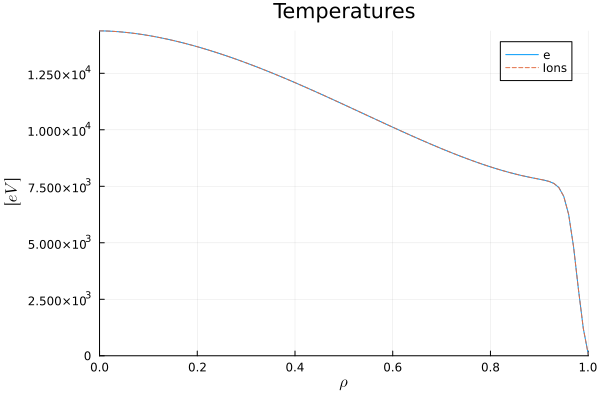

​


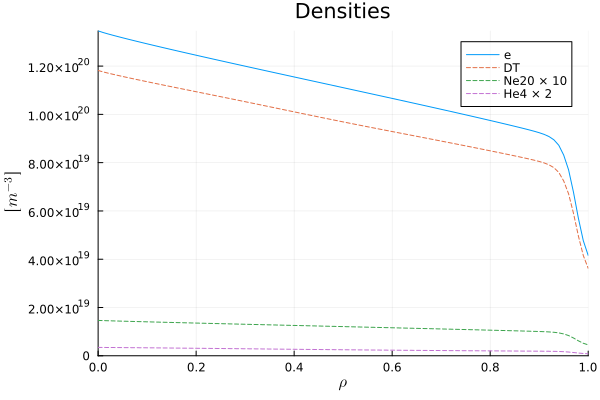

​


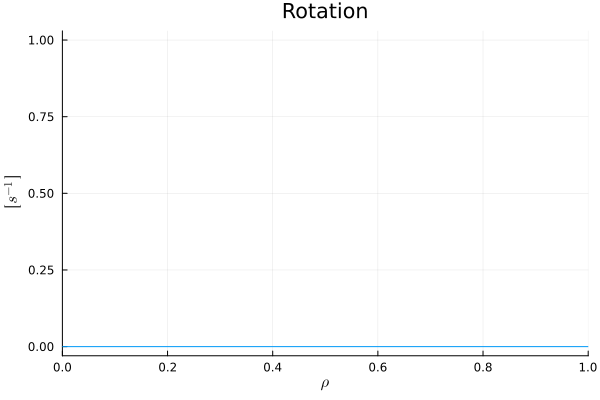

​


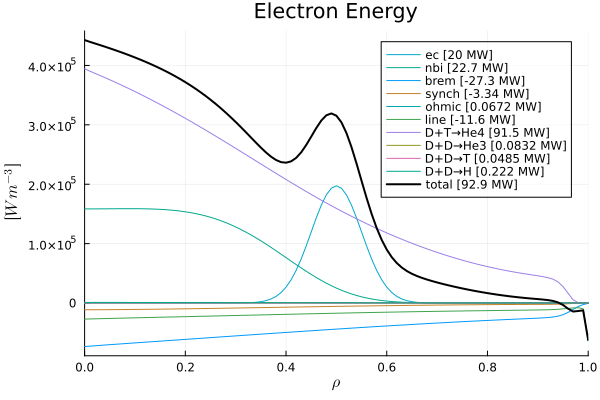

​


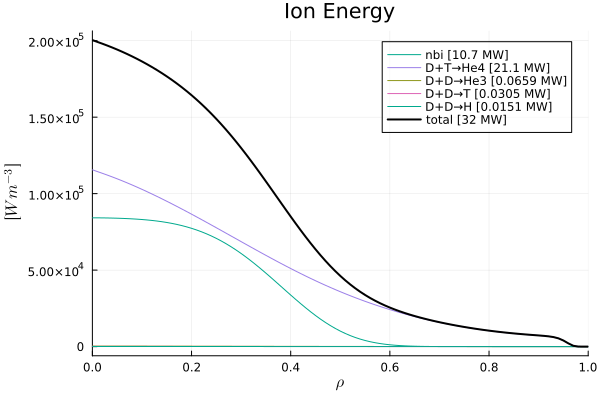

​


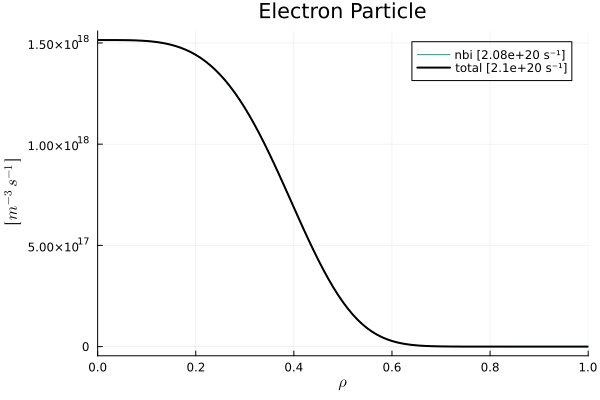

​


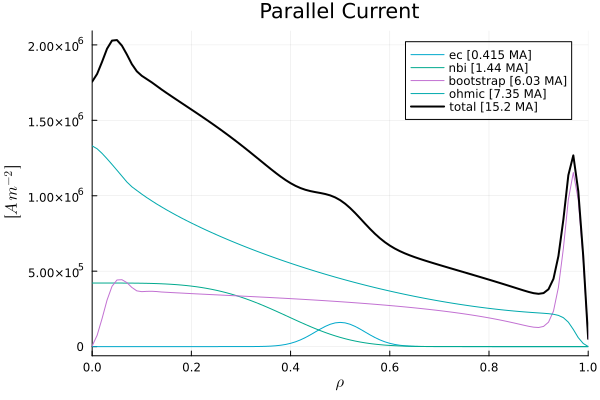

In [142]:
FUSE.digest(dd)